In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy import interp
import torch

from sklearn.metrics import roc_curve, auc, roc_auc_score

/groups/icecube/qgf305/anaconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""

    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                     for a in self.args)

    def __repr__(self):
       return '\n\n'.join(a + '\n' + repr(eval(a))
                       for a in self.args)

In [3]:
indir = "/groups/icecube/peter/storage/Multiclassification/Real/last_one_lvl3MC/dynedge_pid_Real_run_21.5_mill_equal_frac_second_/results.csv"
indir = "/groups/icecube/petersen/GraphNetDatabaseRepository/example_results/train_classification_model/last_one_lvl3MC/dynedge_pid_example/results.csv"
results = pd.read_csv(indir, index_col=[0]).sort_values('event_no').reset_index()

Examine raw data

In [4]:
print(np.unique(results["pid"]))
display("results")

[-16. -14. -12.  -1.  12.  13.  14.  16.]


,index,pid_noise_pred,pid_muon_pred,pid_neutrino_pred,pid,event_no
0,18991,9.876266e-01,0.000943,0.011431,-1.0,3623.0
1,11645,9.642183e-01,0.005838,0.029943,-1.0,4338.0
2,10051,9.860364e-01,0.000126,0.013838,-1.0,4804.0
3,5735,1.000000e+00,0.000000,0.000000,-1.0,10614.0
4,10745,9.867063e-01,0.000453,0.012840,-1.0,10686.0
...,...,...,...,...,...,...
32995,4933,9.818321e-22,0.999998,0.000002,13.0,98594389.0
32996,22392,2.866203e-07,0.991853,0.008147,13.0,98596055.0
32997,13433,1.000000e+00,0.000000,0.000000,-1.0,98602635.0
32998,6135,1.000000e+00,0.000000,0.000000,-1.0,98608605.0


In [5]:
class_options = {1: 0, -1: 0, 13: 1, -13: 1, 12: 2, -12: 2, 14: 2, -14: 2, 16: 2, -16: 2,}
pid_transform = torch.tensor([class_options[int(value)] for value in results["pid"]])


In [6]:
y_test = torch.nn.functional.one_hot(pid_transform)
y_prob = results[["pid_noise_pred","pid_muon_pred","pid_neutrino_pred"]]
print("same shape: ", y_test.shape == y_prob.shape, y_test.shape)

same shape:  True torch.Size([33000, 3])


examine data post transformation

In [7]:
nb_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob.iloc[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

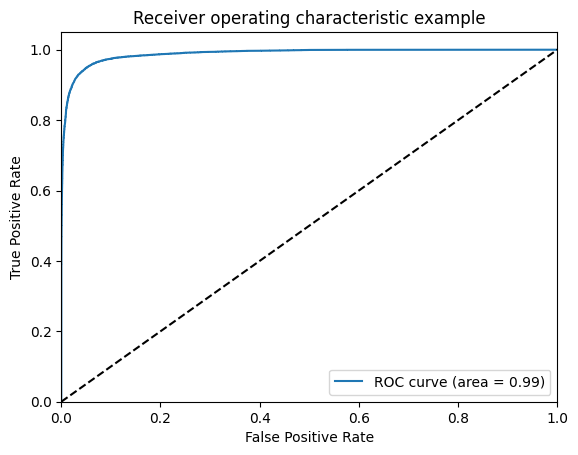

In [8]:
# Plot of a ROC curve for a specific class
test = 2
plt.figure()
plt.plot(fpr[test], tpr[test], label='ROC curve (area = %0.2f)' % roc_auc[test])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [9]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nb_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [10]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)

In [ ]:
np.intersect1d()

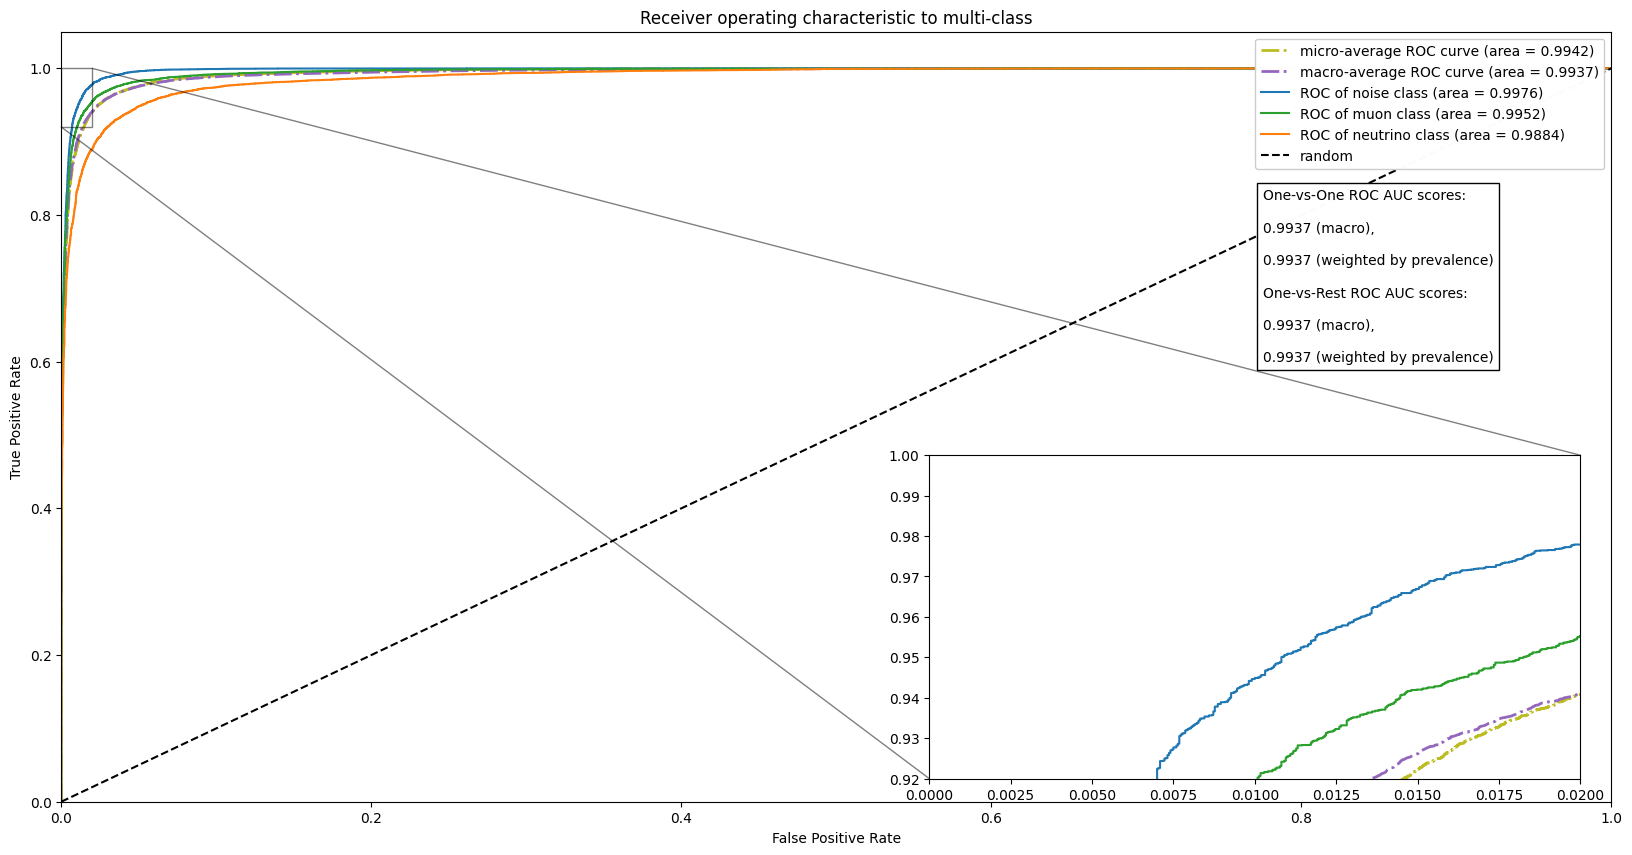

In [11]:
# Plot all ROC curves
fig, ax = plt.subplots(figsize=[20, 10])
# inset axes
axins = ax.inset_axes([0.56, 0.03, 0.42, 0.42])

ax.plot(
      fpr["micro"], tpr["micro"],
      color="tab:olive", linestyle='dashdot',
      label='micro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc["micro"]),
      linewidth=2)

axins.plot(
      fpr["micro"], tpr["micro"],
      color="tab:olive", linestyle='dashdot',
      label='micro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc["micro"]),
      linewidth=2)

ax.plot(
      fpr["macro"], tpr["macro"],
      color="tab:purple", linestyle='dashdot',
      label='macro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc["macro"]),
      linewidth=2)

axins.plot(
      fpr["macro"], tpr["macro"],
      color="tab:purple", linestyle='dashdot',
      label='macro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc["macro"]),
      linewidth=2)


colors=["tab:blue","tab:green","tab:orange"]


for i, item in enumerate(["noise", "muon", "neutrino"]):
      ax.plot(
            fpr[i], tpr[i], 
            color=colors[i], label='ROC of {0} class (area = {1:0.4f})'
                  ''.format(item, roc_auc[i]))
      axins.plot(
            fpr[i], tpr[i], 
            color=colors[i], label='ROC of {0} class (area = {1:0.4f})'
                  ''.format(item, roc_auc[i]))


ax.plot([0, 1], [0, 1], 'k--', label="random")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic to multi-class')
ax.legend(loc="upper right", framealpha=0.99)

# sub region of the original image
x1, x2, y1, y2 = 0, .02, 0.92, 1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.text(
      .775, .6, 
      f"""One-vs-One ROC AUC scores:
      \n{macro_roc_auc_ovo:.4f} (macro), 
      \n{weighted_roc_auc_ovo:.4f} (weighted by prevalence)
      \nOne-vs-Rest ROC AUC scores:
      \n{macro_roc_auc_ovr:.4f} (macro), 
      \n{weighted_roc_auc_ovr:.4f} (weighted by prevalence)""" ,
      fontsize = 10, 
      bbox = dict(facecolor = 'white', alpha = 0.99))

plt.show()